## HW1: Logistic Regression Implementation

### Task 1: Describe a machine learning problem that you would like to solve using Logistic Regression. Clearly state why Logistic regression is the best choice for solving this problem.

A machine learning problem that I would like to solve using Logistic Regression would be determining whether or not a buyer on a shopping website will buy a product after viewing an ad for the product. Logistic Regression is the best choice for solving this problem because this is a classification problem where we can easily use logistic regression to estimate a separator to distinguish between a successful ad and an unsuccessful one given categorical data, especially when we already have the expected output. Since the output should be binary, we cannot use linear regression.

### Task 2:
The dataset to be used will be sourced from https://www.kaggle.com/datasets/dragonheir/logistic-regression?resource=download. This is a dataset containing 5 categories of information: user id, gender, age, salary, and a binary value denoting whether or not the user purchased the advertised product. The dataset is available in the HW1 folder. The following section will conduct Exploratory Data Analysis on this dataset.

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as du
import torch.nn.functional as F
import random
import numpy as np
import pandas as pd
import sklearn
from tqdm import tqdm
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

Load the dataset and look at the data's structure. (The path may need to be adjusted accordingly) 

In [2]:
ads_data = pd.read_csv("../../PIML/HW1/Social_Network_Ads.csv")
ads_data.head(5)

,User ID,Gender,Age,EstimatedSalary,Purchased
0,15624510,Male,19,19000,0
1,15810944,Male,35,20000,0
2,15668575,Female,26,43000,0
3,15603246,Female,27,57000,0
4,15804002,Male,19,76000,0


In [3]:
ads_data.tail(5)

,User ID,Gender,Age,EstimatedSalary,Purchased
395,15691863,Female,46,41000,1
396,15706071,Male,51,23000,1
397,15654296,Female,50,20000,1
398,15755018,Male,36,33000,0
399,15594041,Female,49,36000,1


Confirm that there are no missing values in the data

In [4]:
ads_data.isnull().sum()

User ID            0
Gender             0
Age                0
EstimatedSalary    0
Purchased          0
dtype: int64

Looking at the data, the User ID is irrevalent and will be dropped.

In [5]:
ads_data = ads_data.drop("User ID", axis = 1)

Confirm that the column has been dropped.

In [6]:
ads_data.head(5)

,Gender,Age,EstimatedSalary,Purchased
0,Male,19,19000,0
1,Male,35,20000,0
2,Female,26,43000,0
3,Female,27,57000,0
4,Male,19,76000,0


The genders Male and Female will be converted to binary (0 and 1 respectively) representation so that it can be interpreted by the logistic regression.

In [7]:
g_to_b = {"Male": 0, "Female": 1}
ads_data = ads_data.replace(g_to_b)

Confirm that the data has been remapped.

In [8]:
ads_data.head(5)

,Gender,Age,EstimatedSalary,Purchased
0,0,19,19000,0
1,0,35,20000,0
2,1,26,43000,0
3,1,27,57000,0
4,0,19,76000,0


Scale the dataset by normalizing it.

In [9]:
def normalize(x):
    """
    Normalizes the data within dataframe x
    """
    x_norm = (x-x.min())/(x.max()-x.min())
    return x_norm

In [10]:
ads_data = normalize(ads_data)

Confirm that the data has been normalized.

In [11]:
ads_data.head(5)

,Gender,Age,EstimatedSalary,Purchased
0,0.0,0.023810,0.029630,0.0
1,0.0,0.404762,0.037037,0.0
2,1.0,0.190476,0.207407,0.0
3,1.0,0.214286,0.311111,0.0
4,0.0,0.023810,0.451852,0.0


View the Data

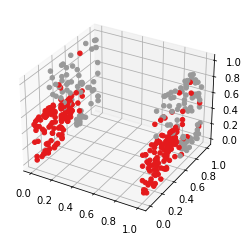

In [12]:
fig = plt.figure()
ax = plt.axes(projection ='3d')
ads_arr = ads_data.to_numpy()
ax.scatter(ads_arr[:,0], ads_arr[:,1], ads_arr[:,2], c=ads_arr[:,3], cmap='Set1', alpha=1)
plt.show()

### Task 3 and 4:
Implementing Logistic Regression with an Optimizer

In [13]:
class LR(nn.Module):
    """
    An implementation of Logistic Regression.
    self.weights: The learned weights from logistic regression.
    self.bias: The learned bias from logistic regression.
    """
    
    def __init__(self, in_dim, batch_size):
        """
        in_dim: the dimensions of the input tensor
        batch_size: the size of the batch
        """
        super(LR, self).__init__()
        
        self.weights = nn.Parameter(torch.randn(in_dim, 1), requires_grad=True)
        self.bias = nn.Parameter(torch.randn(1), requires_grad=True)
    
    def sigmoid(self, a):
        """
        Applies the sigmoid function on the given input tensor.
        a: a pytorch tensor
        """
        return 1.0/(1 + torch.exp(-a))
        
    def get_w(self):
        """
        Returns the weights of the model
        """
        return self.weights
    
    def get_b(self):
        """
        Returns the bias of the model
        """
        return self.bias
    
    def update_grad(self, dw, db):
        """
        Updates the gradients of the model
        dw: the weight gradient
        db: the bias gradient
        """
        self.weights.grad = dw.clone()
        self.bias.grad = db.clone()
        
    def back(self, new_w, new_b):
        """
        Updates the weight and bias
        new_w: the new weight
        new_b: the new bias
        """
        self.weights = nn.Parameter(new_w)
        self.bias = nn.Parameter(new_b)
    
    def forward(self, x):
        """
        Calculates a separator using logistic regression.
        x: the input tensor
        """
        pred = torch.matmul(self.weights.T, x.T) + self.bias
        A = self.sigmoid(pred)
        return A

Create the Dataset Class

In [14]:
class AdDataset(du.Dataset):
    """
    Represents the ad data and is passed into the dataloader to return by batch.
    self.ads: a 2d tensor of arrays of contextual information.
    """
    def __init__(self, ads):
        super(AdDataset, self).__init__() 
        self.ads = ads
        
    def __len__(self):
        """
        Returns the number of samples.
        """
        return len(self.ads)
        
    def __getitem__(self, idx):
        """
        Generates context information and expected classification results
        by batch and returns both as a tuple.
        """
        users = self.ads[idx]
        context = torch.tensor(users[1:4])
        labels = torch.tensor(users[-1])

        return context, labels

Initialize Model Parameters

In [15]:
#pick the device
device = f'cuda:0' if torch.cuda.is_available() else 'cpu'
print(f"using device: {device}")

#Prepare parameters
epochs = 5
learning_rate = 0.02
batch_size = 10
ads = ads_data.to_numpy()
in_dim = ads.shape[1]-1

using device: cpu


Initialize the Dataloader

In [16]:
#split the data into train and test data
train_ads, test_ads = train_test_split(ads, train_size = 0.85, test_size = 0.15)

#load train data
train_data = AdDataset(train_ads)
train_loader = du.DataLoader(dataset = train_data, batch_size = batch_size, shuffle = True)

#load test data
test_data = AdDataset(test_ads)
test_loader = du.DataLoader(dataset = test_data, batch_size = batch_size, shuffle = True)

 ### Task 3: Defining Two forms of Gradient Descent

In [17]:
def calculate_gradients(model, contexts, pred, targets, batch_size):
    """
    Calculates the gradients given the contexts, predictions, batch size, and targets.
    """
    dw = torch.matmul(contexts.T, (pred-targets).T)/batch_size
    db = torch.sum(pred-targets)/batch_size
    model.update_grad(dw, db.unsqueeze(0))
    
    return dw, db

In [18]:
def batch_gd(model, dw, db, learning_rate):
    """
    Minibatch Gradient Descent
    Updates the gradients of the model.
    """
    new_w = model.get_w() - learning_rate*dw
    new_b = model.get_b() - learning_rate*db
    
    model.back(new_w, new_b)

In [19]:
def stochastic_gd(model, optimizer, contexts, pred, targets, learning_rate):
    """
    Stochastic gradient descent
    model: the model being trained
    learning_rate: the model's learning rate
    contexts: the features used to predict
    pred: the predictions
    targets: the actual classifiers
    """
    
    for i in range(pred.shape[1]):
        p = pred[:,i]
        tg = targets[i]
        ct = contexts[i]
        
        #calculate gradients
        dw = torch.matmul(ct.unsqueeze(-1), (p-tg).T)
        db = torch.sum(p-tg)
        dw = dw.unsqueeze(-1)
        model.update_grad(dw, db.unsqueeze(-1))
        
        #step with optimizer
        optimizer.step()
        
        #do gradient descent
        new_w = model.get_w() - learning_rate*dw
        new_b = model.get_b() - learning_rate*db
        model.back(new_w, new_b)

Initialize the Model Without Optimizers

In [20]:
model = LR(in_dim, batch_size)

Train the Models

In [21]:
for epoch in range(1, epochs+1):
    corr = 0
    costs = []
    b_idx = []
    for batch_idx, (contexts, targets) in enumerate(tqdm(train_loader)):
        
        #standardize input to floats
        contexts, targets = contexts.float(), targets.float()
        
        #Calculate Logistic Regression
        probs = model(contexts)
        
        #convert probabilities to 0 or 1 compared to 0.5.
        pred = (probs > 0.5).float()
        
        #Calculate Accuracy
        corr += torch.sum(pred == targets)
        
        #calculate the costs
        cost = torch.sum(targets * torch.log(probs) + (1-targets) * (torch.log(1-probs)))
        costs.append(cost.detach().numpy())
        b_idx.append(batch_idx)
        
        #Update gradients
        dw, db = calculate_gradients(model, contexts, pred, targets, batch_size)
        
        #do gradient descent
        batch_gd(model, dw, db, learning_rate)
    
    total_samp = (len(train_loader)*batch_size)
    print(f"Epoch: {epoch}, Acc: {corr/total_samp:.6f}")

100%|██████████| 34/34 [00:00<00:00, 1602.62it/s]


Epoch: 1, Acc: 0.385294


100%|██████████| 34/34 [00:00<00:00, 1946.10it/s]


Epoch: 2, Acc: 0.711765


100%|██████████| 34/34 [00:00<00:00, 1827.79it/s]


Epoch: 3, Acc: 0.876471


100%|██████████| 34/34 [00:00<00:00, 1750.37it/s]


Epoch: 4, Acc: 0.917647


100%|██████████| 34/34 [00:00<00:00, 2005.15it/s]

Epoch: 5, Acc: 0.935294


Plot the Cost per batch

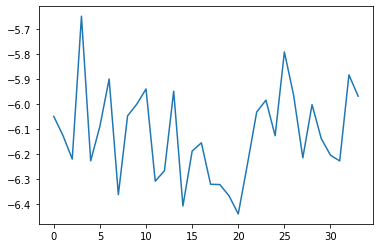

In [22]:
plt.plot(b_idx, costs)

Evaluate the Model

In [23]:
model.eval()

LR()

In [24]:
corr = 0
costs = []
b_idx = []
for batch_idx, (contexts, targets) in enumerate(tqdm(test_loader)):

    #standardize input to floats
    contexts, targets = contexts.float(), targets.float()

    #Calculate Logistic Regression
    probs = model(contexts)

    #convert probabilities to 0 or 1 compared to 0.5.
    pred = (probs > 0.5).float()

    #Calculate Accuracy
    corr += torch.sum(pred == targets)

    #calculate the costs
    cost = torch.sum(targets * torch.log(probs) + (1-targets) * (torch.log(1-probs)))
    costs.append(cost.detach().numpy())
    b_idx.append(batch_idx)
        
total_samp = (len(train_loader)*batch_size)
print(f"Acc: {corr/total_samp:.6f}")

100%|██████████| 6/6 [00:00<00:00, 1717.92it/s]

Acc: 0.164706


Plot the Cost per Batch

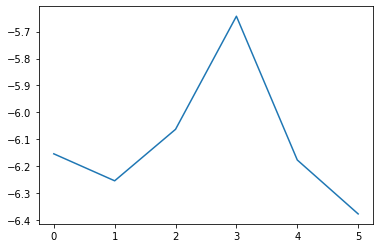

In [25]:
plt.plot(b_idx, costs)

### Task 4: Initialize the Two Models and their Optimizers
The two optimizers are SGD with Momentum and Adadelta

In [26]:
model_ada = LR(in_dim, batch_size)
ada_optimizer = optim.Adadelta(model_ada.parameters(), lr = learning_rate)
model_ada.to(device)
model_ada.train()

LR()

In [27]:
model_sgd = LR(in_dim, batch_size)
sgd_optimizer = optim.SGD(model_sgd.parameters(), lr = learning_rate, momentum = 0.7)
model_sgd = model_sgd.to(device)
model_sgd.train()

LR()

Predict Using the Model

In [28]:
for epoch in range(1, epochs+1):
    sgd_corr, ada_corr, total_samp, sgd_cost, ada_cost = 0, 0, 0, 0, 0
    costs_a = []
    costs_s = []
    b_idx = []
    for batch_idx, (contexts, targets) in enumerate(tqdm(train_loader)):
        
        #clear previous gradients
        sgd_optimizer.zero_grad()
        ada_optimizer.zero_grad()
        
        #standardize input to floats
        contexts, targets = contexts.float(), targets.float()
        
        #Calculate Logistic Regression
        prob_s = model_sgd(contexts)
        prob_a = model_ada(contexts)
        
        #convert probabilities to 0 or 1 compared to 0.5.
        pred_s = (prob_s > 0.5).float()
        pred_a = (prob_a > 0.5).float()
        
        #Calculate Accuracy
        sgd_corr += torch.sum(pred_s == targets)
        ada_corr += torch.sum(pred_a == targets)
        
        #calculate the costs
        sgd_cost += torch.sum(targets * torch.log(prob_s) + (1-targets) * (torch.log(1-prob_s)))
        ada_cost += torch.sum(targets * torch.log(prob_a) + (1-targets) * (torch.log(1-prob_a)))
        costs_a.append(sgd_cost.detach().numpy())
        costs_s.append(ada_cost.detach().numpy())
        b_idx.append(batch_idx)
        
        #Update gradients
        dw_s, db_s = calculate_gradients(model_sgd, contexts, pred_s, targets, batch_size)
        dw_a, db_a = calculate_gradients(model_ada, contexts, pred_a, targets, batch_size)
        
        #do gradient descent
        batch_gd(model_sgd, dw_s, db_s, learning_rate)
        batch_gd(model_ada, dw_a, db_a, learning_rate)
        
        #step with the optimizer
        sgd_optimizer.step()
        ada_optimizer.step()
    
    total_samp = (len(train_loader)*batch_size)
    print(f"Epoch: {epoch}, SGD Acc: {sgd_corr/total_samp:.6f}, SGD Cost: {sgd_cost/total_samp:.6f}, Ada Acc: {ada_corr/total_samp:.6f}, Ada Cost: {ada_cost/total_samp:.6f}")

100%|██████████| 34/34 [00:00<00:00, 1004.33it/s]


Epoch: 1, SGD Acc: 0.667647, SGD Cost: -0.541846, Ada Acc: 1.000000, Ada Cost: -0.317172


100%|██████████| 34/34 [00:00<00:00, 1011.49it/s]


Epoch: 2, SGD Acc: 0.835294, SGD Cost: -0.491601, Ada Acc: 1.000000, Ada Cost: -0.317172


100%|██████████| 34/34 [00:00<00:00, 1015.99it/s]


Epoch: 3, SGD Acc: 0.923529, SGD Cost: -0.480371, Ada Acc: 1.000000, Ada Cost: -0.317172


100%|██████████| 34/34 [00:00<00:00, 1036.11it/s]


Epoch: 4, SGD Acc: 0.958824, SGD Cost: -0.475644, Ada Acc: 1.000000, Ada Cost: -0.317172


100%|██████████| 34/34 [00:00<00:00, 1019.57it/s]

Epoch: 5, SGD Acc: 0.964706, SGD Cost: -0.473709, Ada Acc: 1.000000, Ada Cost: -0.317172


Plot the Costs

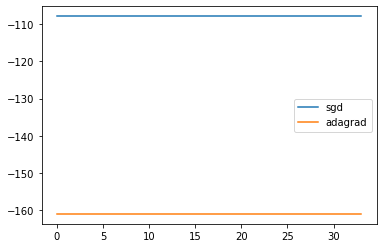

In [29]:
plt.plot(b_idx, costs_s, label = "sgd")
plt.plot(b_idx, costs_a, label = "adagrad")
plt.legend()
plt.show()

Evaluate the Training on the Testing Set for Mini-batch Gradient Descent

In [30]:
model_sgd.eval()
model_ada.eval()

LR()

In [31]:
sgd_corr, ada_corr, sgd_cost, ada_cost = 0., 0., 0., 0.
costs_a = []
costs_s = []
b_idx = []
for batch_idx, (contexts, targets) in enumerate(tqdm(test_loader)):

    #standardize input to floats
    contexts, targets = contexts.float(), targets.float()

    #Calculate Logistic Regression
    prob_s = model_sgd(contexts)
    prob_a = model_ada(contexts)

    #convert probabilities to 0 or 1 compared to 0.5.
    pred_s = (prob_s > 0.5).float()
    pred_a = (prob_a > 0.5).float()

    #Calculate Accuracy
    sgd_corr += torch.sum(pred_s == targets)
    ada_corr += torch.sum(pred_a == targets)
    
    #calculate the costs
    sgd_cost += torch.sum(targets * torch.log(prob_s) + (1-targets) * (torch.log(1-prob_s)))
    ada_cost += torch.sum(targets * torch.log(prob_a) + (1-targets) * (torch.log(1-prob_a)))
    costs_a.append(sgd_cost.detach().numpy())
    costs_s.append(ada_cost.detach().numpy())
    b_idx.append(batch_idx)
        
total_samp = (len(test_loader)*batch_size)
print(f"SGD Acc: {sgd_corr/total_samp:.6f}, SGD Cost: {sgd_cost/total_samp:.6f}, Ada Acc: {ada_corr/total_samp:.6f}, Ada Cost: {ada_cost/total_samp:.6f}")

100%|██████████| 6/6 [00:00<00:00, 1363.34it/s]

SGD Acc: 0.950000, SGD Cost: -0.453904, Ada Acc: 1.000000, Ada Cost: -0.326706


Plot the Costs

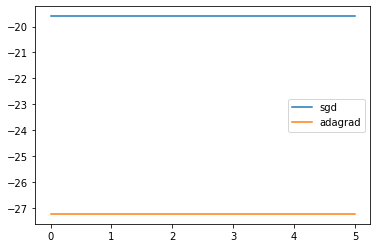

In [32]:
plt.plot(b_idx, costs_s, label = "sgd")
plt.plot(b_idx, costs_a, label = "adagrad")
plt.legend()
plt.show()

Repeat with the stochastic gradient descent variant

In [33]:
model_sgd = LR(in_dim, batch_size)
model_ada = LR(in_dim, batch_size)

sgd_optimizer = optim.SGD(model_sgd.parameters(), lr = learning_rate, momentum = 0.8)
ada_optimizer = optim.Adadelta(model_ada.parameters(), lr = learning_rate)

model_sgd, model_ada = model_sgd.to(device), model_ada.to(device)
model_sgd.train()
model_ada.train()

LR()

In [34]:
for epoch in range(1, epochs+1):
    sgd_corr, ada_corr, total_samp, sgd_cost, ada_cost = 0, 0, 0, 0, 0
    costs_s = []
    costs_a = []
    b_idx = []
    for batch_idx, (contexts, targets) in enumerate(tqdm(train_loader)):
        
        #standardize input to floats
        contexts, targets = contexts.float(), targets.float()
        
        #Calculate Logistic Regression
        prob_s = model_sgd(contexts)
        prob_a = model_ada(contexts)
        
        #convert probabilities to 0 or 1 compared to 0.5.
        pred_s = (prob_s > 0.5).float()
        pred_a = (prob_a > 0.5).float()
        
        #calculate the costs
        sgd_cost += torch.sum(targets * torch.log(prob_s) + (1-targets) * (torch.log(1-prob_s)))
        ada_cost += torch.sum(targets * torch.log(prob_a) + (1-targets) * (torch.log(1-prob_a)))
        costs_a.append(sgd_cost.detach().numpy())
        costs_s.append(ada_cost.detach().numpy())
        b_idx.append(batch_idx)
        
        #calculate accuracy
        sgd_corr += torch.sum(pred_s == targets)
        ada_corr += torch.sum(pred_a == targets)
        total_samp += batch_size
        
        #Do Gradient Descent
        stochastic_gd(model_sgd, sgd_optimizer, contexts, pred_s, targets, learning_rate)
        stochastic_gd(model_ada, ada_optimizer, contexts, pred_a, targets, learning_rate)
           
    #Display Accuracy per Epoch
    print(f"Epoch: {epoch}, SGD Acc: {sgd_corr/total_samp:.6f}, SGD Cost: {sgd_cost/total_samp:.6f}, Ada Acc: {ada_corr/total_samp:.6f}, Ada Cost: {ada_cost/total_samp:.6f}")

  0%|          | 0/34 [00:00<?, ?it/s]/tmp/ipykernel_840/2375580596.py:17: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matricesor `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at  /home/conda/feedstock_root/build_artifacts/pytorch-recipe_1647409388182/work/aten/src/ATen/native/TensorShape.cpp:2318.)
  dw = torch.matmul(ct.unsqueeze(-1), (p-tg).T)
100%|██████████| 34/34 [00:00<00:00, 206.22it/s]


Epoch: 1, SGD Acc: 0.835294, SGD Cost: -0.621188, Ada Acc: 0.888235, Ada Cost: -0.635953


100%|██████████| 34/34 [00:00<00:00, 207.43it/s]


Epoch: 2, SGD Acc: 0.985294, SGD Cost: -0.585172, Ada Acc: 0.991176, Ada Cost: -0.615226


100%|██████████| 34/34 [00:00<00:00, 216.70it/s]


Epoch: 3, SGD Acc: 0.997059, SGD Cost: -0.580648, Ada Acc: 0.994118, Ada Cost: -0.611633


100%|██████████| 34/34 [00:00<00:00, 237.27it/s]


Epoch: 4, SGD Acc: 0.994118, SGD Cost: -0.576831, Ada Acc: 1.000000, Ada Cost: -0.608946


100%|██████████| 34/34 [00:00<00:00, 230.15it/s]

Epoch: 5, SGD Acc: 1.000000, SGD Cost: -0.575104, Ada Acc: 1.000000, Ada Cost: -0.608946


Plot the Costs

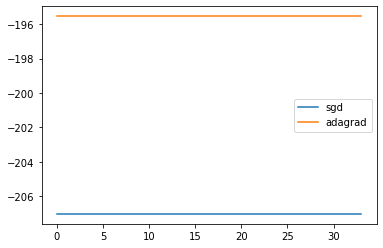

In [35]:
plt.plot(b_idx, costs_s, label = "sgd")
plt.plot(b_idx, costs_a, label = "adagrad")
plt.legend()
plt.show()

In [36]:
model_sgd.eval()
model_ada.eval()

LR()

Evaluate Prediction by Stochastic Gradient Descent

In [37]:
sgd_corr, ada_corr, total_samp, sgd_cost, ada_cost = 0, 0, 0, 0, 0
costs_s = []
costs_a = []
b_idx = []
for batch_idx, (contexts, targets) in enumerate(tqdm(test_loader)):

    #standardize input to floats
    contexts, targets = contexts.float(), targets.float()

    #Calculate Logistic Regression
    prob_s = model_sgd(contexts)
    prob_a = model_ada(contexts)

    #convert probabilities to 0 or 1 compared to 0.5.
    pred_s = (prob_s > 0.5).float()
    pred_a = (prob_a > 0.5).float()

    #Calculate Accuracy
    sgd_corr += torch.sum(pred_s == targets)
    ada_corr += torch.sum(pred_a == targets)

    #calculate the costs
    sgd_cost += torch.sum(targets * torch.log(prob_s) + (1-targets) * (torch.log(1-prob_s)))
    ada_cost += torch.sum(targets * torch.log(prob_a) + (1-targets) * (torch.log(1-prob_a)))
    costs_a.append(sgd_cost.detach().numpy())
    costs_s.append(ada_cost.detach().numpy())
    b_idx.append(batch_idx)

total_samp = (len(test_loader)*batch_size)
print(f"SGD Acc: {sgd_corr/total_samp:.6f}, SGD Cost: {sgd_cost/total_samp:.6f}, Ada Acc: {ada_corr/total_samp:.6f}, Ada Cost: {ada_cost/total_samp:.6f}")

100%|██████████| 6/6 [00:00<00:00, 1183.44it/s]

SGD Acc: 1.000000, SGD Cost: -0.567949, Ada Acc: 1.000000, Ada Cost: -0.611112


Plot the Costs

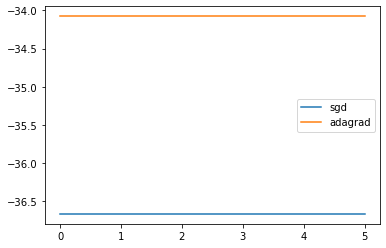

In [38]:
plt.plot(b_idx, costs_s, label = "sgd")
plt.plot(b_idx, costs_a, label = "adagrad")
plt.legend()
plt.show()

### Outcomes
This dataset relied on scaling to make good predictions. When unscaled, the accuracy would fluctuate around 50%. I found that for my dataset, minibatch gradient descent worked better compared to stochastic gradient descent. This is likely because the dataset used has multiple outliers with very high salaries that purchase after viewing an ad. As a result, stochastic gradient descent would be influenced by this and alter the weights more than necessary. Mini-batch gradient descent, however, is less influenced by this issue because it calculates the gradient for multiple entries at once, therefore averaging and decreasing the influence of these outliers. With regards to optimizers, I found that Adagrad generally peformed better than SGD with Momentum as an optimizer as its accuracy would increase at a much faster pace compared to SGD with momentum. Compared to the original implementation of gradient descent, the model performs better with an optimizer, which allows us to better adjust the weights of the model. Therefore, optimizers should be used in tasks such as these that require a more controlled form of gradient descent.